Iñigo Martin Melero

## Participante 20

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_20_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


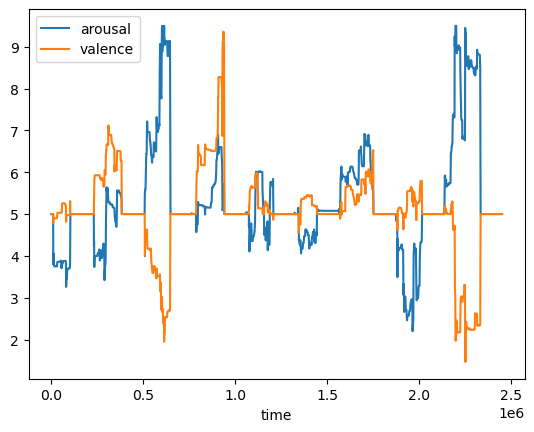

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_20_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.892  34.599  31.029  34.937  32.517    11.106     8.234   
1              1  0.905  34.550  31.009  34.947  32.506    11.189     8.070   
2              2  0.918  34.502  30.989  34.957  32.496    11.271     7.906   
3              3  0.925  34.655  31.008  34.976  32.502    11.556     8.107   
4              4  0.922  34.771  30.962  34.986  32.509    11.640     8.069   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.734  35.163  24.069  33.360  29.642     5.482     7.699   
2451580  2451580  0.734  35.333  24.023  33.398  29.645     5.562     7.780   
2451581  2451581  0.741  35.469  24.026  33.389  29.645     5.523     7.700   
2451582  2451582  0.731  35.528  24.089  33.370  29.638     5.400     7.699   
2451583  2451583  0.747  35.164  24.042  33.379  29.656     5.562     7.861   

         emg_trap  video  
0          12.791     10

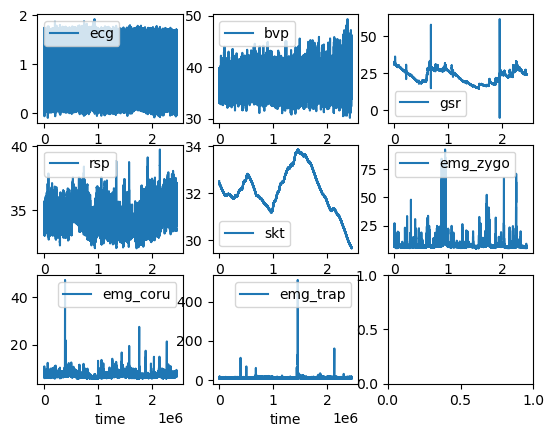

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

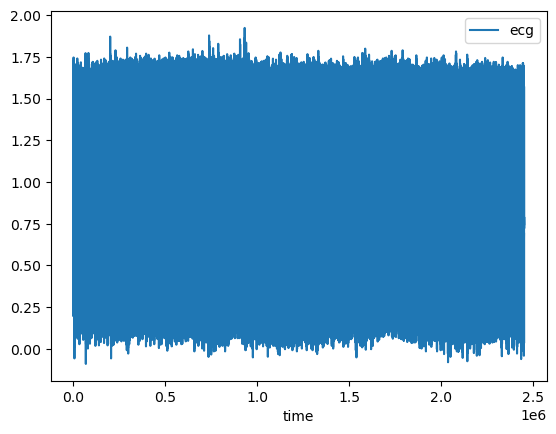

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

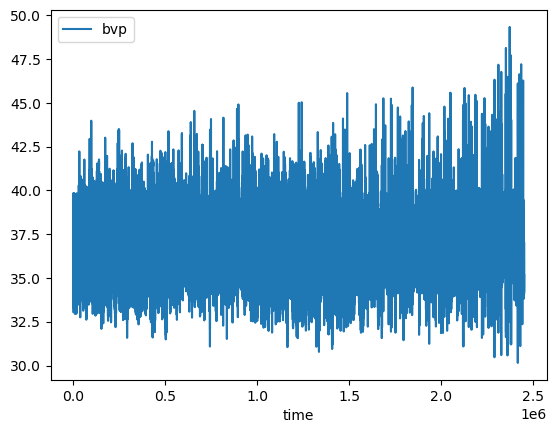

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

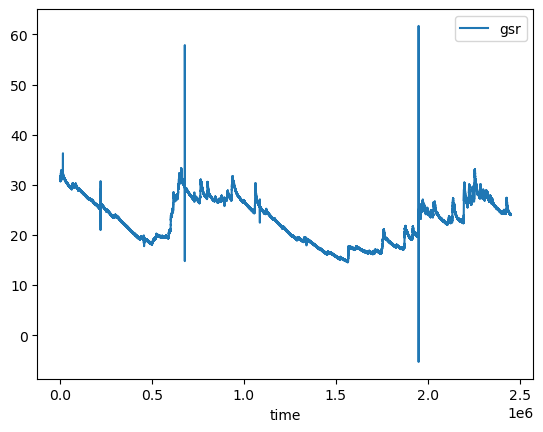

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

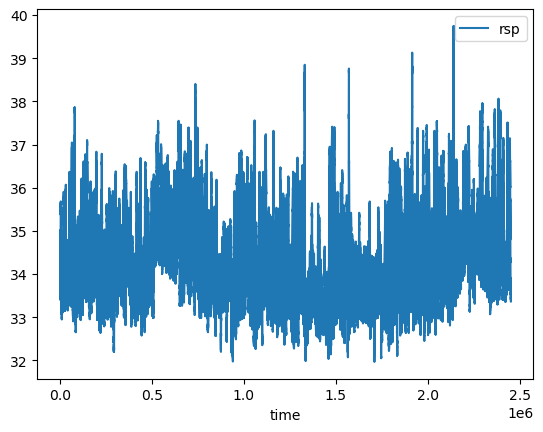

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

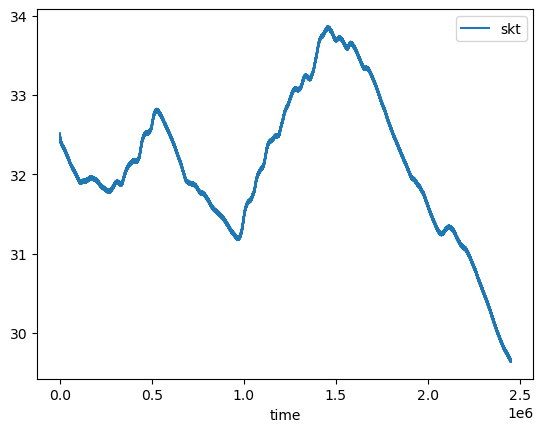

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

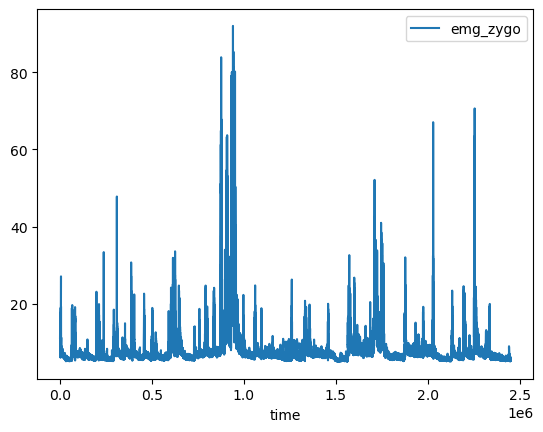

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

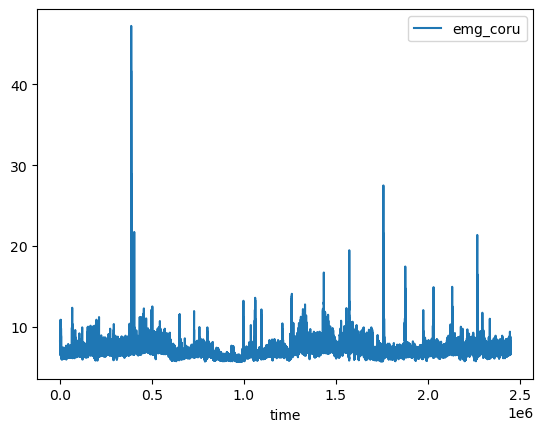

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

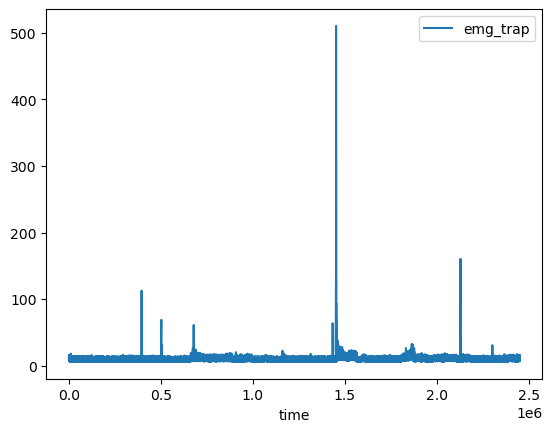

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

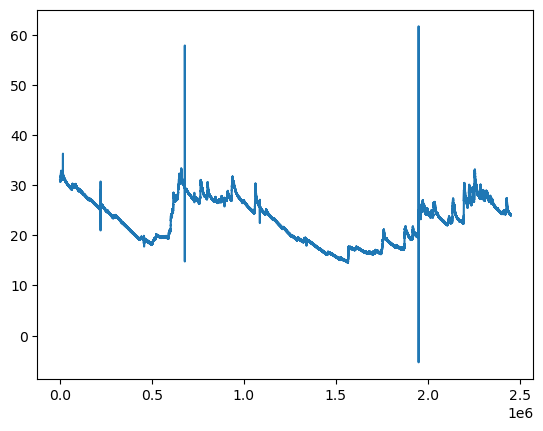

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

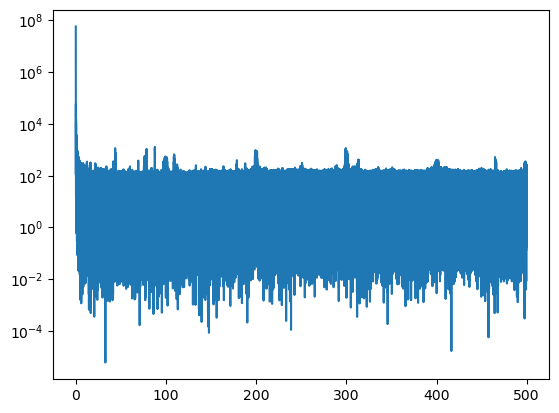

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

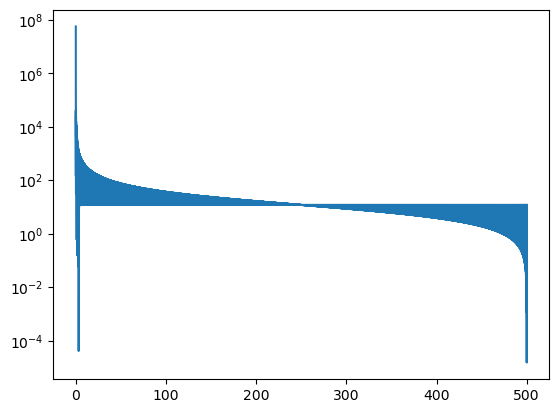

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

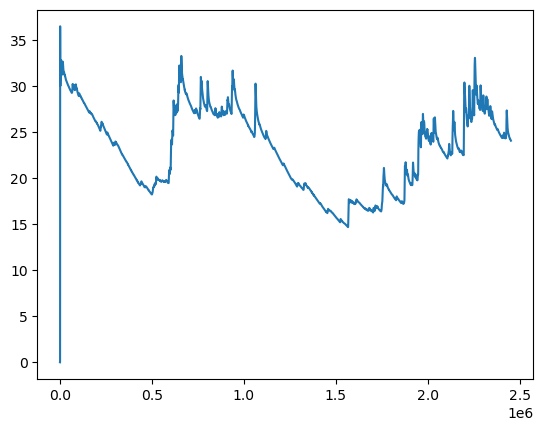

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  24.074
2451580  24.073
2451581  24.073
2451582  24.073
2451583  24.073

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

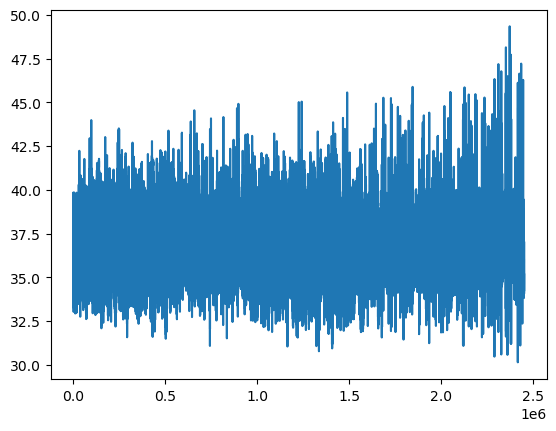

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

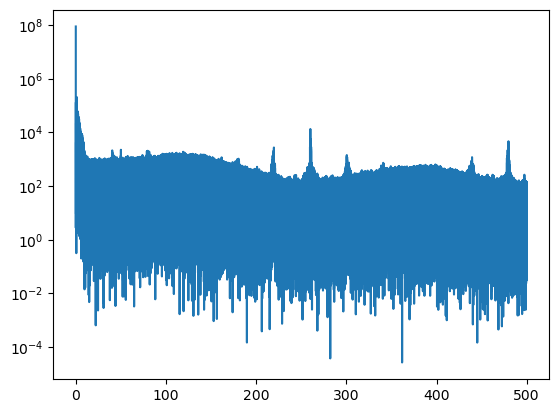

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

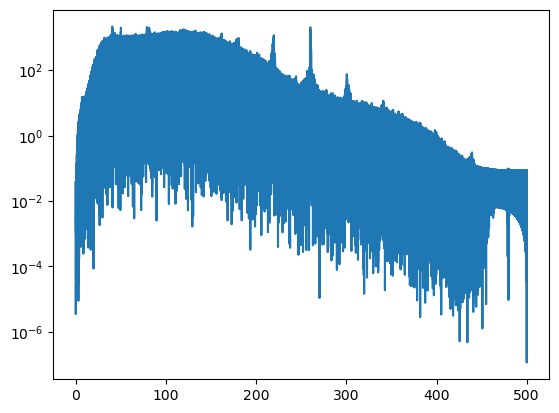

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

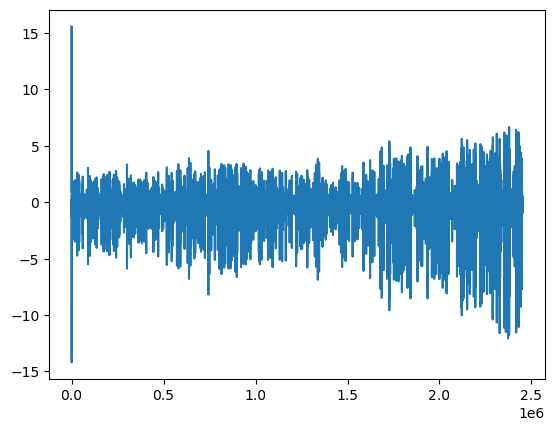

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.961
1        42.362
2        49.610
3        52.582
4        45.714
...         ...
2451579  36.990
2451580  37.083
2451581  37.126
2451582  37.138
2451583  37.159

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

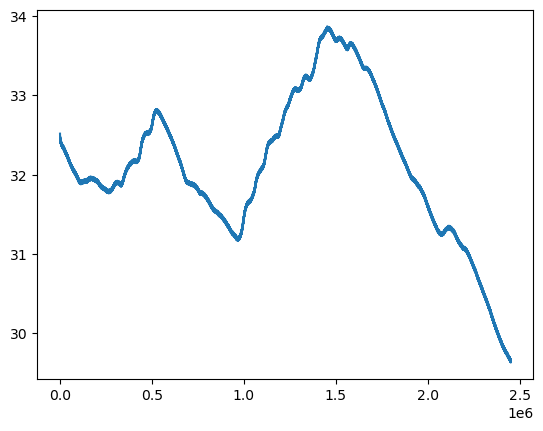

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

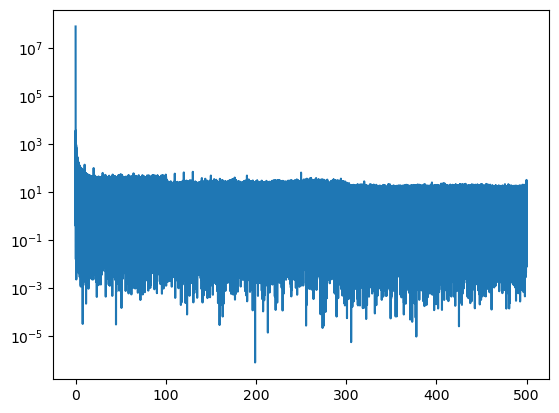

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

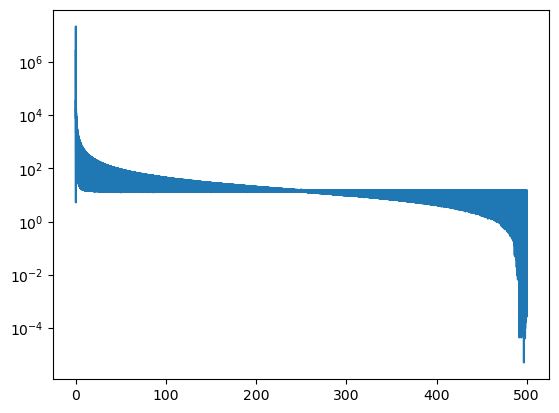

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

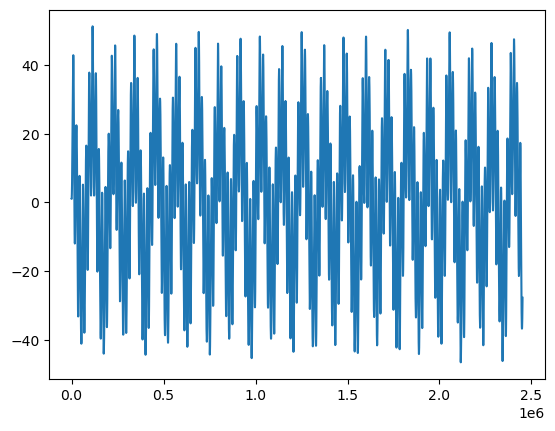

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        41.042
1        41.042
2        41.041
3        41.042
4        41.042
...         ...
2451579  12.307
2451580  12.313
2451581  12.318
2451582  12.323
2451583  12.329

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.892  34.937    11.106     8.234    12.791     10
1              1  0.905  34.947    11.189     8.070    12.832     10
2              2  0.918  34.957    11.271     7.906    12.873     10
3              3  0.925  34.976    11.556     8.107    13.158     10
4              4  0.922  34.986    11.640     8.069    13.283     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.734  33.360     5.482     7.699     9.954     12
2451580  2451580  0.734  33.398     5.562     7.780    10.161     12
2451581  2451581  0.741  33.389     5.523     7.700    10.326     12
2451582  2451582  0.731  33.370     5.400     7.699    10.490     12
2451583  2451583  0.747  33.379     5.562     7.861    10.776     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.892  34.937    11.106     8.234    12.791     10  37.961   
1              1  0.905  34.947    11.189     8.070    12.832     10  42.362   
2              2  0.918  34.957    11.271     7.906    12.873     10  49.610   
3              3  0.925  34.976    11.556     8.107    13.158     10  52.582   
4              4  0.922  34.986    11.640     8.069    13.283     10  45.714   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.734  33.360     5.482     7.699     9.954     12  36.990   
2451580  2451580  0.734  33.398     5.562     7.780    10.161     12  37.083   
2451581  2451581  0.741  33.389     5.523     7.700    10.326     12  37.126   
2451582  2451582  0.731  33.370     5.400     7.699    10.490     12  37.138   
2451583  2451583  0.747  33.379     5.562     7.861    10.776     12  37.159   

            gsr     skt  
0         0.000  41.042  
1         0.000  41.042  
2         0.000  41.041  
3         0.000  41.042  
4         0.000  41.042  
...         ...     ...  
2451579  24.074  12.307  
2451580  24.073  12.313  
2451581  24.073  12.318  
2451582  24.073  12.323  
2451583  24.073  12.329  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.395093  0.654209  0.589982  0.793161  0.373217  0.011985   
221502    221502  0.385078  0.658563  0.589982  0.793085  0.373217  0.011465   
221503    221503  0.394592  0.659863  0.589982  0.793009  0.373217  0.010944   
221504    221504  0.390085  0.658959  0.589982  0.792934  0.374373  0.011465   
221505    221505  0.383575  0.659128  0.589928  0.792847  0.374373  0.010944   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.441162  0.658789  0.669549  0.356783  0.278627  0.032833   
2331580  2331580  0.444166  0.661277  0.669549  0.356869  0.277342  0.034394   
2331581  2331581  0.441162  0.659976  0.669495  0.356945  0.276186  0.032858   
2331582  2331582  0.441162  0.660994  0.669495  0.357032  0.274900  0.033366   
2331583  2331583  0.441162  0.666591  0.669495  0.357107  0.277342  0.033366   

         emg_coru  emg_trap  video  
221501   0.081304  0.016911      4  
221502   0.083861  0.018177      4  
221503   0.083925  0.018193      4  
221504   0.081304  0.018193      4  
221505   0.076063  0.015628      4  
...           ...       ...    ...  
2331579  0.097028  0.007790      7  
2331580  0.099648  0.006508      7  
2331581  0.089230  0.004560      7  
2331582  0.099585  0.005194      7  
2331583  0.097028  0.005843      7  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.395093  0.654209  0.589982  0.373217  0.793161  0.011985   
221502    221502  0.385078  0.658563  0.589982  0.373217  0.793085  0.011465   
221503    221503  0.394592  0.659863  0.589982  0.373217  0.793009  0.010944   
221504    221504  0.390085  0.658959  0.589982  0.374373  0.792934  0.011465   
221505    221505  0.383575  0.659128  0.589928  0.374373  0.792847  0.010944   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.441162  0.658789  0.669549  0.278627  0.356783  0.032833   
2331580  2331580  0.444166  0.661277  0.669549  0.277342  0.356869  0.034394   
2331581  2331581  0.441162  0.659976  0.669495  0.276186  0.356945  0.032858   
2331582  2331582  0.441162  0.660994  0.669495  0.274900  0.357032  0.033366   
2331583  2331583  0.441162  0.666591  0.669495  0.277342  0.357107  0.033366   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
221540   0.378568  0.664669  0.589873  0.378101  0.790154  0.009395  0.062959   
221560   0.378568  0.651722  0.589873  0.383113  0.788619  0.011985  0.083861   
221580   0.372058  0.654492  0.589928  0.385555  0.787072  0.015109  0.102269   
221600   0.367051  0.656132  0.590036  0.385555  0.785515  0.011465  0.086545   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.434652  0.652400  0.670202  0.283640  0.350175  0.031284  0.081304   
2331520  0.437656  0.655792  0.670039  0.282354  0.351851  0.032845  0.094407   
2331540  0.432649  0.648669  0.669875  0.278627  0.353517  0.032312  0.120614   
2331560  0.441162  0.658167  0.669712  0.278627  0.355193  0.027119  0.099776   
2331580  0.444166  0.661277  0.669549  0.277342  0.356869  0.034394  0.099648   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1      0.378568  0.664669  0.589873  0.378101  0.790154  0.009395  0.062959   
2      0.378568  0.651722  0.589873  0.383113  0.788619  0.011985  0.083861   
3      0.372058  0.654492  0.589928  0.385555  0.787072  0.015109  0.102269   
4      0.367051  0.656132  0.590036  0.385555  0.785515  0.011465  0.086545   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.434652  0.652400  0.670202  0.283640  0.350175  0.031284  0.081304   
63500  0.437656  0.655792  0.670039  0.282354  0.351851  0.032845  0.094407   
63501  0.432649  0.648669  0.669875  0.278627  0.353517  0.032312  0.120614   
63502  0.441162  0.658167  0.669712  0.278627  0.355193  0.027119  0.099776   
63503  0.444166  0.661277  0.669549  0.277342  0.356869  0.034394  0.099648   

       emg_trap  valence  arousal  
0      0.020790    5.000    5.000  
1      0.014963    5.000    5.000  
2      0.014298    5.000    5.000  
3      0.016879    5.000    5.000  
4      0.016911    5.000    5.000  
...         ...      ...      ...  
63499  0.007141    2.344    8.645  
63500  0.005843    2.344    8.643  
63501  0.005827    2.344    8.642  
63502  0.003278    2.343    8.641  
63503  0.006508    2.344    8.639  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1      0.378568  0.664669  0.589873  0.378101  0.790154  0.009395  0.062959   
2      0.378568  0.651722  0.589873  0.383113  0.788619  0.011985  0.083861   
3      0.372058  0.654492  0.589928  0.385555  0.787072  0.015109  0.102269   
4      0.367051  0.656132  0.590036  0.385555  0.785515  0.011465  0.086545   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.606910  0.664839  0.670963  0.289809  0.343470  0.039600  0.086417   
63496  0.523285  0.654605  0.670746  0.287238  0.345146  0.036477  0.089038   
63497  0.464196  0.661446  0.670582  0.284796  0.346823  0.030230  0.083925   
63498  0.444166  0.659524  0.670419  0.282354  0.348499  0.030763  0.070821   
63499  0.434652  0.652400  0.670202  0.283640  0.350175  0.031284  0.081304   

       emg_trap  valence  arousal  
0      0.020790    5.000    5.000  
1      0.014963    5.000    5.000  
2      0.014298    5.000    5.000  
3      0.016879    5.000    5.000  
4      0.016911    5.000    5.000  
...         ...      ...      ...  
63495  0.010371    2.344    8.655  
63496  0.009706    2.344    8.653  
63497  0.007790    2.344    8.651  
63498  0.007141    2.344    8.648  
63499  0.007141    2.344    8.645  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
 1   0.378568  0.664669  0.589873  0.378101  0.790154  0.009395  0.062959   
 2   0.378568  0.651722  0.589873  0.383113  0.788619  0.011985  0.083861   
 3   0.372058  0.654492  0.589928  0.385555  0.787072  0.015109  0.102269   
 4   0.367051  0.656132  0.590036  0.385555  0.785515  0.011465  0.086545   
 5   0.363545  0.656980  0.590145  0.388125  0.783969  0.010424  0.076063   
 6   0.365048  0.660259  0.590308  0.391852  0.782422  0.009370  0.089102   
 7   0.409614  0.657884  0.590526  0.389410  0.780854  0.006780  0.112816   
 8   0.414622  0.671793  0.590743  0.390567  0.779307  0.006767  0.115436   
 9   0.439159  0.656640  0.590961  0.394294  0.777750  0.008329  0.123298   
 10  0.390085  0.654266  0.591179  0.386840  0.776182  0.007808  0.131160   
 11  0.350526  0.658393  0.591450  0.386840  0.774625  0.012506  0.136401   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       193       194       195  \
0     0.020790  0.378568  0.664669  ...  0.514772  0.645502  0.591777   
1     0.013633  0.577366  0.659015  ...  0.391587  0.657262  0.592103   
2     0.008455  0.390085  0.653248  ...  0.468703  0.652570  0.593354   
3     0.010403  0.454181  0.656697  ...  0.555834  0.655905  0.598847   
4     0.020790  0.643465  0.655623  ...  0.511768  0.660711  0.605537   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.011052  0.414622  0.650139  ...  0.662994  0.662068  0.692663   
2536  0.011021  0.521783  0.655453  ...  0.434151  0.658845  0.687497   
2537  0.013016  0.483726  0.658167  ...  0.449174  0.655566  0.680861   
2538  0.012984  0.444166  0.659807  ...  0.467201  0.655453  0.675586   
2539  0.005162  0.469204  0.658110  ...  0.434652  0.652400  0.670202   

           196       197       198       199       200  valence  arousal  
0     0.325922  0.754196  0.013014  0.133717  0.016879  5.00000  5.00000  
1     0.264876  0.714864  0.008862  0.078683  0.007790  5.00000  5.00000  
2     0.176584  0.676591  0.009916  0.089166  0.011701  5.00000  5.00000  
3     0.146768  0.640492  0.013534  0.073442  0.019508  5.00000  5.00000  
4     0.126847  0.607518  0.010424  0.199425  0.013649  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.467678  0.193072  0.022942  0.089230  0.010403  2.33400  8.81800  
2536  0.398021  0.228111  0.020847  0.120614  0.013649  2.33400  8.81800  
2537  0.344557  0.266914  0.030750  0.052413  0.011052  2.33400  8.81700  
2538  0.315898  0.308139  0.027081  0.162672  0.005811  2.33480  8.80588  
2539  0.283640  0.350175  0.031284  0.081304  0.007141  2.34068  8.70344  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub20.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub20.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub20.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub20.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.385078  0.657715  0.589928  0.376944  0.791701  0.010411  0.076063   
1     0.560841  0.660429  0.591614  0.323352  0.752617  0.010932  0.123298   
2     0.380070  0.652230  0.592158  0.261277  0.713306  0.010944  0.104954   
3     0.460691  0.666365  0.593463  0.172985  0.675098  0.009383  0.104890   
4     0.600401  0.658054  0.599119  0.148053  0.639108  0.013014  0.097028   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.427641  0.659241  0.697341  0.543632  0.163992  0.022930  0.120678   
2536  0.623435  0.659015  0.692446  0.462794  0.194381  0.021355  0.107446   
2537  0.475213  0.657997  0.687225  0.398021  0.229604  0.021901  0.149569   
2538  0.437656  0.655905  0.680590  0.345714  0.268536  0.025532  0.052349   
2539  0.477216  0.657262  0.675368  0.311014  0.309815  0.023971  0.141515   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub20.csv', index=False)